In [1]:
import pandas as pd

pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from collections import defaultdict
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [2]:
root_dir='/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open'

cus = pd.read_csv(os.path.join(root_dir,"cus_info.csv"))
iem = pd.read_csv(os.path.join(root_dir,"iem_info_20210902.csv"))
hist = pd.read_csv(os.path.join(root_dir,"sort_hist.csv"))
train = pd.read_csv(os.path.join(root_dir,"stk_hld_train.csv"))
test = pd.read_csv(os.path.join(root_dir,"stk_hld_test.csv"))
best_param= pd.read_csv("/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/날짜별코드및제출파일/best_param.csv")
submission = pd.read_csv(os.path.join(root_dir,"sample_submission.csv"))

In [3]:
_2015=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2015.xls')
_2016=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2016.xls')
_2017=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2017.xls')
_2018=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2018.xls')
_2019=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2019.xls')
_2020=pd.read_excel('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/2020.xls')
holiday=pd.concat([_2015,_2016,_2017,_2018,_2019,_2020],axis=0)
print(len(holiday))
holiday['일자 및 요일']

91


0     2015-01-01
1     2015-02-18
2     2015-02-19
3     2015-02-20
4     2015-05-01
5     2015-05-05
6     2015-05-25
7     2015-08-14
8     2015-09-28
9     2015-09-29
10    2015-10-09
11    2015-12-25
12    2015-12-31
0     2016-01-01
1     2016-02-08
2     2016-02-09
3     2016-02-10
4     2016-03-01
5     2016-04-13
6     2016-05-05
7     2016-05-06
8     2016-06-06
9     2016-08-15
10    2016-09-14
11    2016-09-15
12    2016-09-16
13    2016-10-03
14    2016-12-30
0     2017-01-27
1     2017-01-30
2     2017-03-01
3     2017-05-01
4     2017-05-03
5     2017-05-05
6     2017-05-09
7     2017-06-06
8     2017-08-15
9     2017-10-02
10    2017-10-03
11    2017-10-04
12    2017-10-05
13    2017-10-06
14    2017-10-09
15    2017-12-25
16    2017-12-29
0     2018-01-01
1     2018-02-15
2     2018-02-16
3     2018-03-01
4     2018-05-01
5     2018-05-07
6     2018-05-22
7     2018-06-06
8     2018-06-13
9     2018-08-15
10    2018-09-24
11    2018-09-25
12    2018-09-26
13    2018-10-

In [4]:
import holidays
from datetime import date
kr_holidays=holidays.KR()
def count_workday(start:int,end:int)->int:
    start=str(start)
    end=str(end)
    start=start[:4]+'-'+start[4:6]+'-'+start[6:]
    end=end[:4]+'-'+end[4:6]+'-'+end[6:] 
    df=pd.date_range(start,end,freq='D')
    cnt=0
    for days in df:
        t=str(days.year)+'-'+str(days.month)+'-'+str(days.day)
        # 토요일,일요일 그리고 Korean 공휴일,거래 휴무일이면 제외 ( 거래 휴무일만 넣으니 )
        if days.weekday()==5 or days.weekday()==6 or (date(days.year,days.month,days.day) in kr_holidays)or (t in list(holiday['일자 및 요일'])):
            continue
        cnt+=1

    return cnt
count_workday('20161124','20170111')

33

In [5]:
print(f"cus.shape:{cus.shape}")
print(f'iem.shape:{iem.shape}')
print(f'hist.shape:{hist.shape}')
print(f'train.shape:{train.shape}')
print(f'test.shape:{test.shape}')

cus.shape:(10000, 10)
iem.shape:(3079, 5)
hist.shape:(2573839, 9)
train.shape:(681472, 4)
test.shape:(70596, 6)


In [6]:
train["hist_d"] = train["hold_d"]*0.5
train.hist_d = np.trunc(train["hist_d"])

In [7]:
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])
id_list=list(train_data['act_id'].unique())

In [8]:
id_list=hist['act_id'].unique()
print(id_list)


id_list=list(train_data['act_id'].unique())
id_list
train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)
'''
hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)
hist['past_d']=0
hist=hist.sort_values(by='bse_dt',ascending=True)
'''


['607dc3c33af3b8e3db84edde47274d493b3929f3313f88baff0076f14a516992'
 '43a0eb89f16d3a46767794dda9c31cd15e1ff9daf3333260a0d8a3bdcc8958a4'
 '17586bfba8192872026f8876e596ad6b0438e645644546c9abbeda49f1ab5afb' ...
 '72408c021493364112b3090bd30e9b97ffaa5c9fe52daa4c5fd4ee4a64901695'
 'caea0c7ad6979ed693619882b78439e6150c4b9dab984ac3fec25b5db0473af9'
 '0f1e12de5bb9c56690f96e27f3d22369e9525fbab2e313c304c554ddaf06fd67']


'\nhist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]\nhist = hist.fillna(0)\nhist[\'past_d\']=0\nhist=hist.sort_values(by=\'bse_dt\',ascending=True)\n'

In [9]:
hist[hist['act_id']=='1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6']


,Unnamed: 0,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,past_d
415,9,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A003620,270.0,2087100.0,5000.0,7730.0,0
428,2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0,9590.0,0
445,22,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A017810,50.0,8900000.0,5000.0,178000.0,0
941,21,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160115,A017810,0.0,0.0,5000.0,0.0,10
25077,7,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170706,A005490,15.0,4410000.0,5000.0,294000.0,0
28619,6,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170904,A005880,150.0,5265000.0,5000.0,35100.0,0
1512046,1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0,69500.0,0
1512066,19,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A033780,20.0,1576000.0,5000.0,78800.0,0
1512077,4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0,51400.0,0
1544681,16,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200629,A035720,20.0,5350000.0,500.0,267500.0,0


In [10]:
hist

,Unnamed: 0,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,past_d
0,2088811,607dc3c33af3b8e3db84edde47274d493b3929f3313f88...,20160104,A076610,1.0,5450.0,500.0,5450.0,0
1,803320,43a0eb89f16d3a46767794dda9c31cd15e1ff9daf33332...,20160104,A063160,620.0,16337000.0,2500.0,26350.0,0
2,809726,17586bfba8192872026f8876e596ad6b0438e645644546...,20160104,A032620,1041.0,3617475.0,500.0,3475.0,0
3,2088277,607dc3c33af3b8e3db84edde47274d493b3929f3313f88...,20160104,A037560,1.0,12400.0,2500.0,12400.0,0
4,801535,407a1110ee9394a0d7778e13de9327117182a68e545372...,20160104,A034230,688.0,11764800.0,500.0,17100.0,0
...,...,...,...,...,...,...,...,...,...
2573834,1835808,b75fdf8ba56903189f860223c52a603b4660b1c2cfacc1...,20201230,A215360,29.0,690200.0,500.0,23800.0,0
2573835,2345209,4fb3d5ee388f0ab9686680d24ac36cc8930c2f03003b7a...,20201230,A033270,550.0,36520000.0,500.0,66400.0,93
2573836,339710,f8cf44bedd1141468c899e405235d512586be26aea9e0a...,20201230,A008700,10.0,34100.0,500.0,3410.0,0
2573837,1294435,f1ac89a1c9f3c8200fb3d79449ff785e14a18e7e0b53f9...,20201230,A003300,2.0,21800.0,1000.0,10900.0,2


In [11]:
hist.reset_index(drop=True,inplace=True)

In [12]:
hist.drop(columns='Unnamed: 0',inplace=True)

In [13]:
hist

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,past_d
0,607dc3c33af3b8e3db84edde47274d493b3929f3313f88...,20160104,A076610,1.0,5450.0,500.0,5450.0,0
1,43a0eb89f16d3a46767794dda9c31cd15e1ff9daf33332...,20160104,A063160,620.0,16337000.0,2500.0,26350.0,0
2,17586bfba8192872026f8876e596ad6b0438e645644546...,20160104,A032620,1041.0,3617475.0,500.0,3475.0,0
3,607dc3c33af3b8e3db84edde47274d493b3929f3313f88...,20160104,A037560,1.0,12400.0,2500.0,12400.0,0
4,407a1110ee9394a0d7778e13de9327117182a68e545372...,20160104,A034230,688.0,11764800.0,500.0,17100.0,0
...,...,...,...,...,...,...,...,...
2573834,b75fdf8ba56903189f860223c52a603b4660b1c2cfacc1...,20201230,A215360,29.0,690200.0,500.0,23800.0,0
2573835,4fb3d5ee388f0ab9686680d24ac36cc8930c2f03003b7a...,20201230,A033270,550.0,36520000.0,500.0,66400.0,93
2573836,f8cf44bedd1141468c899e405235d512586be26aea9e0a...,20201230,A008700,10.0,34100.0,500.0,3410.0,0
2573837,f1ac89a1c9f3c8200fb3d79449ff785e14a18e7e0b53f9...,20201230,A003300,2.0,21800.0,1000.0,10900.0,2


In [14]:
def make_past_d(df,act):
    frame=df[df['act_id']==act]
    #id 
    iem_list=list(frame['iem_cd'].unique())
    for iem in iem_list:
        f=frame[frame['iem_cd']==iem]
        # id,iem 동일한것 가져오고
        f_index=list(f.index)
        cnt=0
        for i in range(len(f_index)):
            
            if i==0:
                hist.loc[f_index[i],'past_d']=0
                continue
            a=hist.loc[f_index[i-1],'bse_dt']
            b=hist.loc[f_index[i],'bse_dt']
            cnt+=count_workday(a,b)
            hist.loc[f_index[i],'past_d']=cnt

            if hist.loc[f_index[i],'bnc_qty']==0:
                cnt=0  
'''
pd.set_option('display.max_rows',500)
pd.set_option('display.min_rows',300)
#make_past_d(hist,'1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6')
          
for idx in id_list:
    make_past_d(hist,idx)
hist[hist['act_id']=='1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6']
hist.to_csv('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/sorting_hist.csv')
'''

"\npd.set_option('display.max_rows',500)\npd.set_option('display.min_rows',300)\n#make_past_d(hist,'1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6')\n          \nfor idx in id_list:\n    make_past_d(hist,idx)\nhist[hist['act_id']=='1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6']\nhist.to_csv('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/open/sorting_hist.csv')\n"

In [15]:
# a=train_data[train_data["byn_dt"] < train_data["bse_dt"]]

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)
#'BTP_CFC_CD'.lower()
train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt",'IEM_KRL_NM'.lower(),'mrz_pdt_tp_sgm_cd'], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt",'IEM_KRL_NM'.lower(),'mrz_pdt_tp_sgm_cd'], axis = 1)

object_columns = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
# object 형인 column 들을 labdel encode (by factorize)
for column in object_columns:
    train_data[column]=pd.factorize(train_data[column])[0]


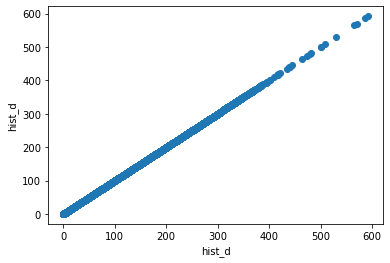

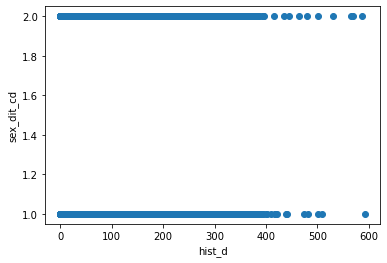

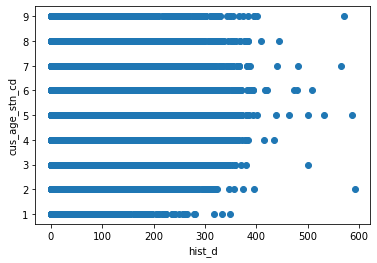

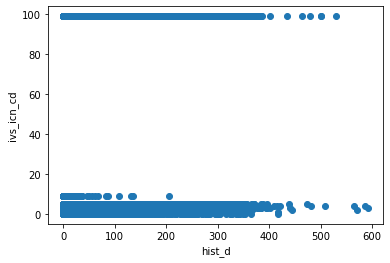

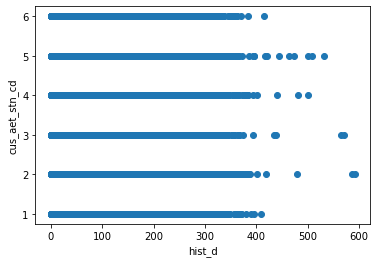

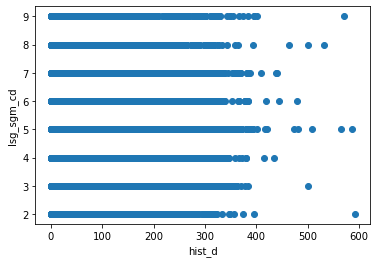

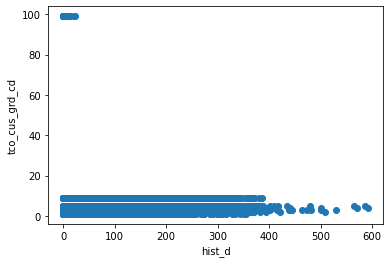

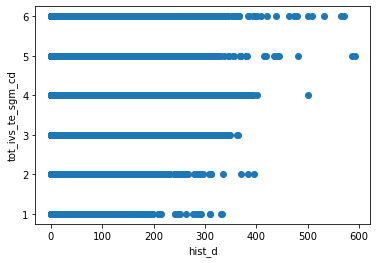

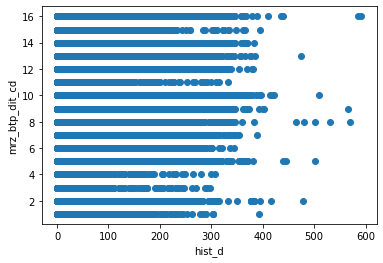

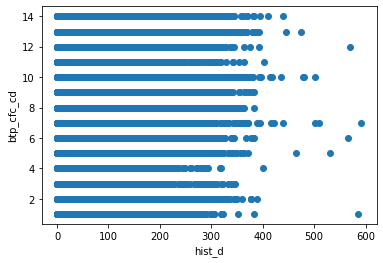

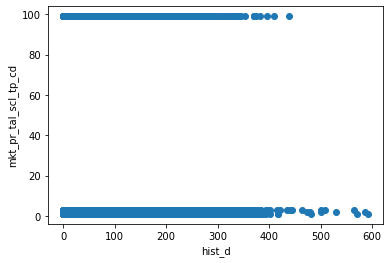

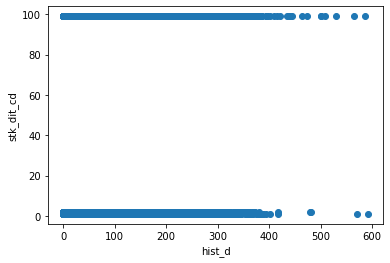

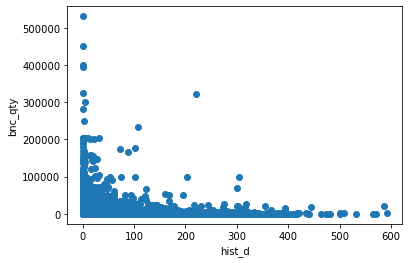

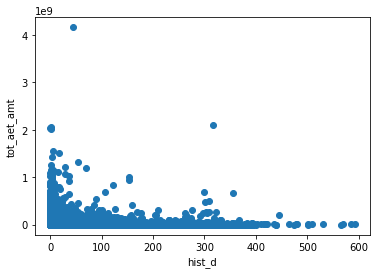

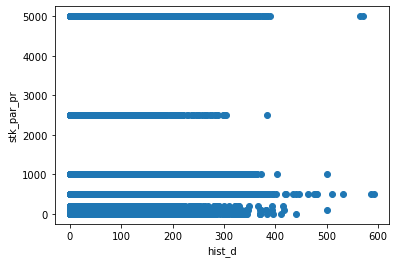

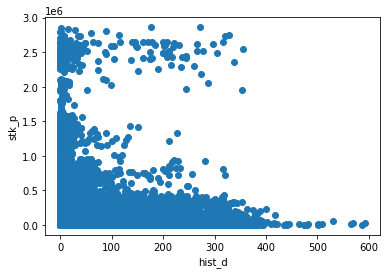

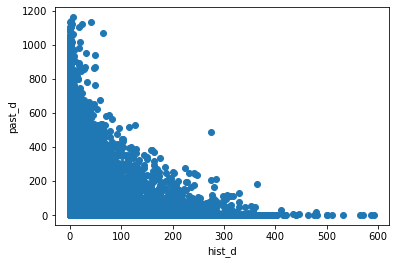

In [16]:
def scattered_column(df,column):
    plt.scatter(x=df['hist_d'],y=df[column])
    plt.ylabel(column,fontsize=10)
    plt.xlabel('hist_d',fontsize=10)
    plt.show()
for column in train_data.columns:
    scattered_column(train_data,column)

In [17]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,past_d
0,5.0,1,9,3,2,9,5,5,8,1,1,1,274.0,11782000.0,5000.0,43000.0,0
1,40.0,1,9,3,2,9,5,5,8,9,1,1,2.0,4990000.0,5000.0,2495000.0,0
2,2.0,1,9,3,2,9,5,5,8,12,2,99,786.0,14619600.0,1000.0,18600.0,0
3,11.0,1,9,3,2,9,5,5,8,8,2,1,60.0,462000.0,500.0,7700.0,0
4,162.0,1,9,3,2,9,5,5,8,10,3,99,183.0,8125200.0,5000.0,44400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,3,4,3,8,10,3,99,199.0,3532250.0,500.0,17750.0,0
681468,0.0,1,4,4,2,3,4,3,8,8,2,99,488.0,22960400.0,500.0,47050.0,0
681469,0.0,1,4,4,2,3,4,3,8,2,2,99,2210.0,9204650.0,500.0,4165.0,0
681470,0.0,1,4,4,2,3,4,3,8,2,3,99,285.0,2721750.0,500.0,9550.0,0


In [18]:
train_data['hist_d']=(train_data['hist_d']**2)/(train_data['hist_d']+train_data['past_d'])
test_data['hist_d']=(test_data['hist_d']**2)/(test_data['hist_d']+test_data['past_d'])

train_data['past_d']=(train_data['past_d']**2)/(train_data['hist_d']+train_data['past_d'])
test_data['past_d']=(test_data['past_d']**2)/(test_data['hist_d']+test_data['past_d'])

        
        
        
        

In [19]:
train_data['stk_p']=np.log1p(train_data['stk_p'])
test_data['stk_p']=np.log1p(test_data['stk_p'])
#train_data['hist_d']/=train_data['mkt_pr_tal_scl_tp_cd']
#test_data['hist_d']/=test_data['mkt_pr_tal_scl_tp_cd']

In [20]:
train_data['tot_aet_amt']=np.log1p(train_data['tot_aet_amt'])
test_data['tot_aet_amt']=np.log1p(test_data['tot_aet_amt'])

/opt/homebrew/Caskroom/miniforge/base/envs/PSNR/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


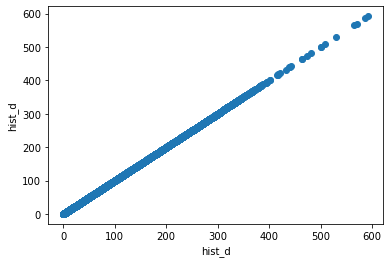

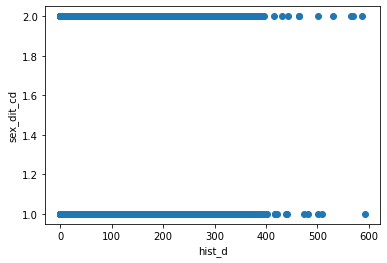

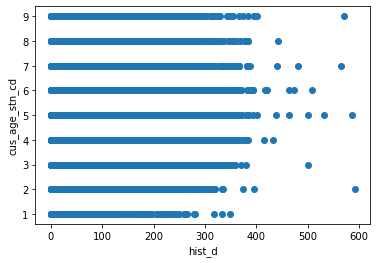

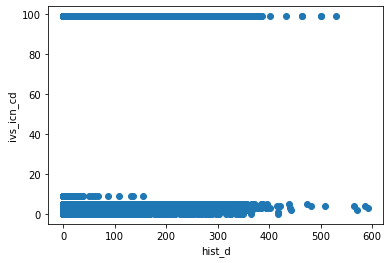

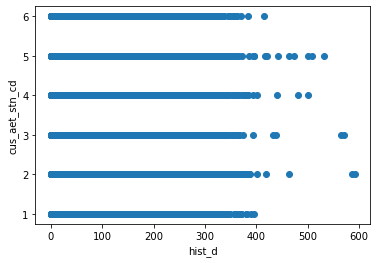

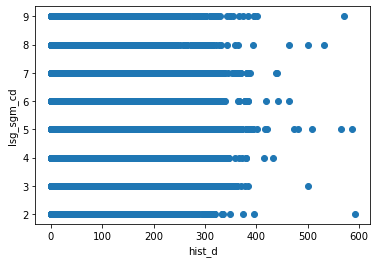

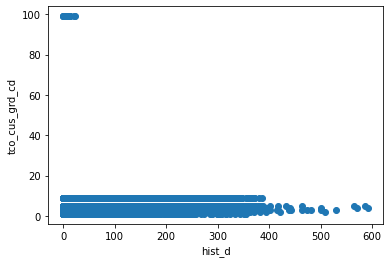

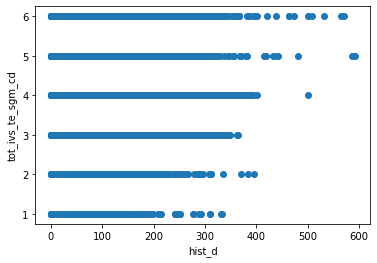

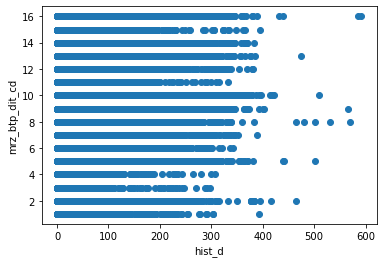

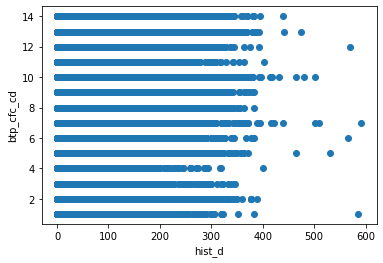

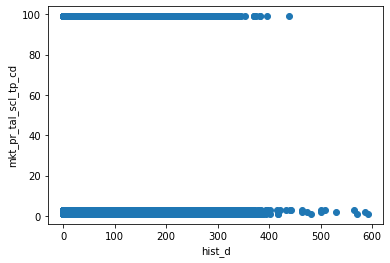

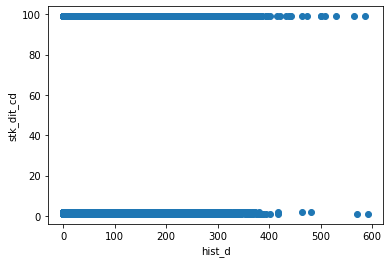

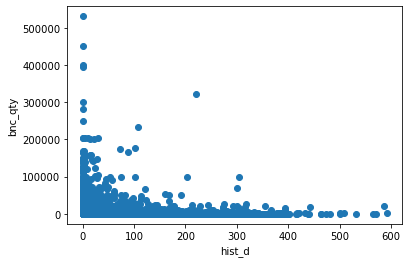

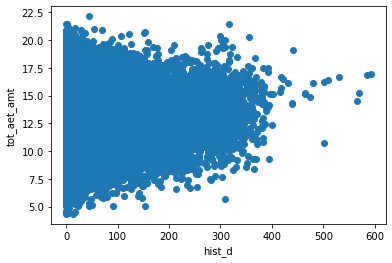

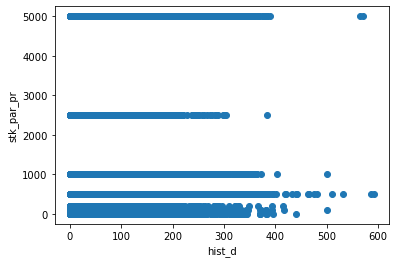

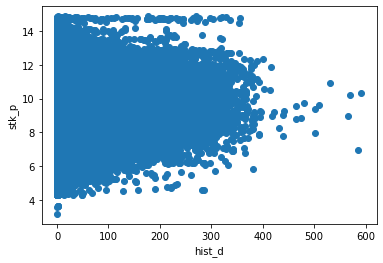

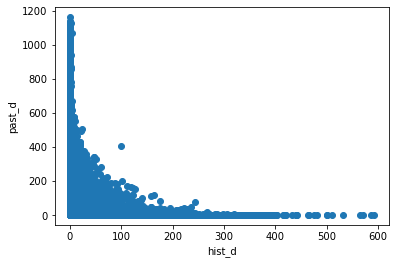

In [21]:
for column in train_data.columns:
    scattered_column(train_data,column)

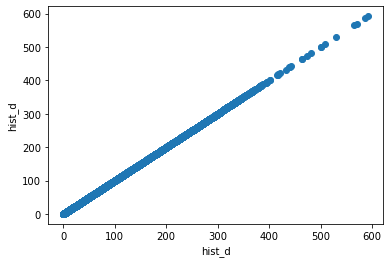

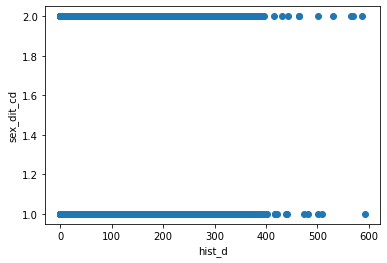

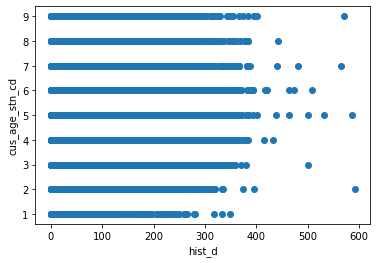

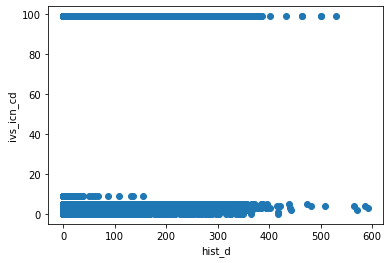

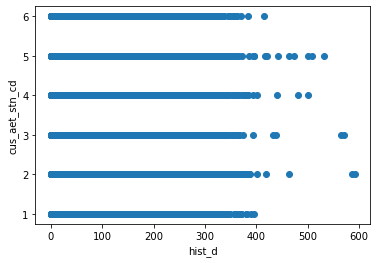

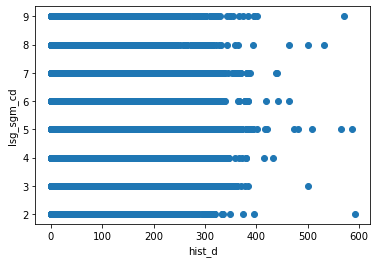

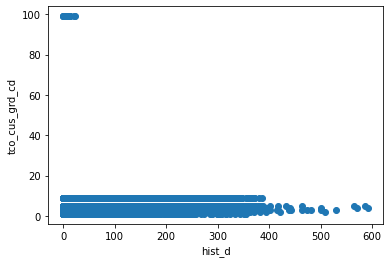

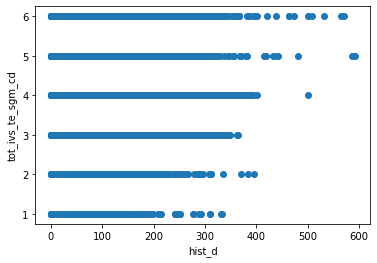

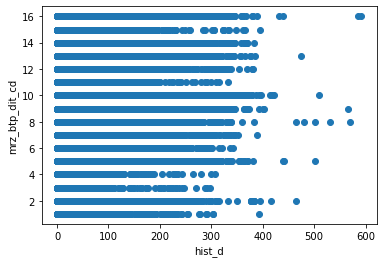

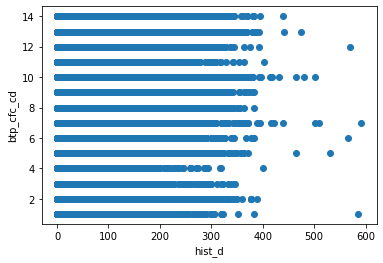

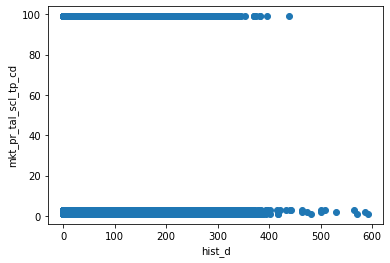

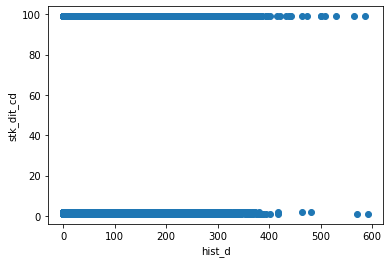

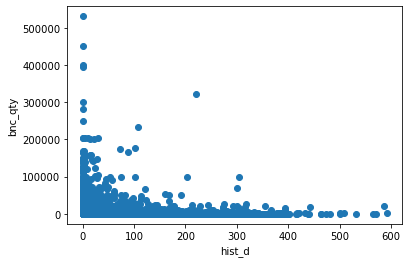

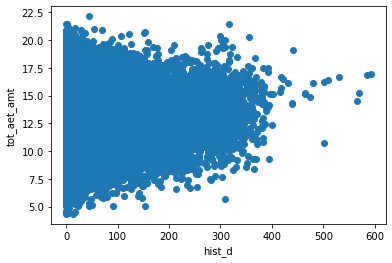

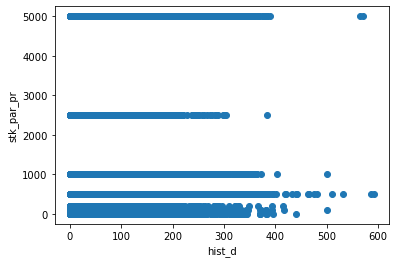

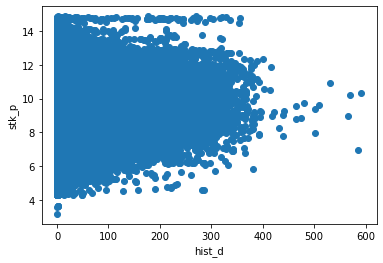

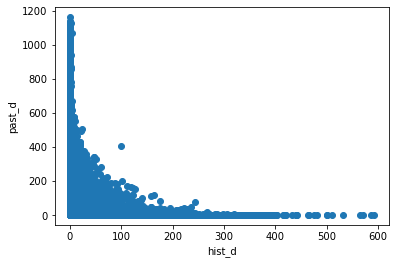

In [22]:
for column in train_data.columns:
    scattered_column(train_data,column)

In [23]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

In [24]:

gridparam={'n_estimators':[1000,2000,3000],
          'max_depth':[5,10,15,20,25],
           'bagging_fraction':[0.7,0.8,0.9],
           'feature_fraction':[0.7,0.8,0.9]}

In [25]:
train_data
column_1=[ 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
        'lsg_sgm_cd', 'tco_cus_grd_cd',
       'mrz_btp_dit_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd','btp_cfc_cd'
]
#train_data=pd.get_dummies(train_data,columns=column_1)
#test_data=pd.get_dummies(test_data,columns=column_1)
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,past_d
0,5.0,1,9,3,2,9,5,5,8,1,1,1,274.0,16.282084,5000.0,10.668979,0.0
1,40.0,1,9,3,2,9,5,5,8,9,1,1,2.0,15.422947,5000.0,14.729800,0.0
2,2.0,1,9,3,2,9,5,5,8,12,2,99,786.0,16.497874,1000.0,9.830971,0.0
3,11.0,1,9,3,2,9,5,5,8,8,2,1,60.0,13.043322,500.0,8.949105,0.0
4,162.0,1,9,3,2,9,5,5,8,10,3,99,183.0,15.910481,5000.0,10.701017,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,NaN,1,4,4,2,3,4,3,8,10,3,99,199.0,15.077446,500.0,9.784197,NaN
681468,NaN,1,4,4,2,3,4,3,8,8,2,99,488.0,16.949282,500.0,10.758987,NaN
681469,NaN,1,4,4,2,3,4,3,8,2,2,99,2210.0,16.035219,500.0,8.334712,NaN
681470,NaN,1,4,4,2,3,4,3,8,2,3,99,285.0,14.816786,500.0,9.164401,NaN


In [26]:
param={'objective':"regression",
                        'n_jobs':-1,
                            
       'reg_alpha':0.5,
       'reg_lambda':0.5,
       'subsample':0.8,
       'max_depth': 5, 
       'n_estimators': 3000,
        'random_state':2021}
xgb_param={'objective':"reg:squarederror",
                        'n_jobs':-1,
           'reg_alpha':0.5,
           'reg_alpha':0.5,
       'reg_lambda':0.2,
                
       'max_depth': 5, 
       'n_estimators': 3000,
        'random_state':2021}

[0]	validation_0-rmse:39.34843	validation_1-rmse:39.98361
[500]	validation_0-rmse:0.44256	validation_1-rmse:0.64139
[1000]	validation_0-rmse:0.41779	validation_1-rmse:0.63089
[1500]	validation_0-rmse:0.40557	validation_1-rmse:0.62861
[2000]	validation_0-rmse:0.39563	validation_1-rmse:0.62843
[2030]	validation_0-rmse:0.39512	validation_1-rmse:0.62841
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.92408	training's l2: 0.853925	valid_1's rmse: 1.5377	valid_1's l2: 2.36452
Early stopping, best iteration is:
[636]	training's rmse: 0.860666	training's l2: 0.740745	valid_1's rmse: 1.5335	valid_1's l2: 2.35161


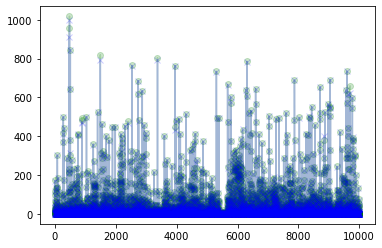

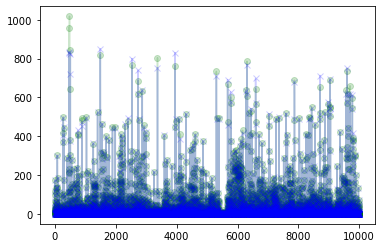

1.53349614387416
[0]	validation_0-rmse:39.45918	validation_1-rmse:38.88868
[500]	validation_0-rmse:0.44459	validation_1-rmse:0.69860
[1000]	validation_0-rmse:0.41795	validation_1-rmse:0.68764
[1500]	validation_0-rmse:0.40554	validation_1-rmse:0.68649
[2000]	validation_0-rmse:0.39578	validation_1-rmse:0.68695
[2072]	validation_0-rmse:0.39439	validation_1-rmse:0.68717
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[68]	training's rmse: 1.69599	training's l2: 2.8764	valid_1's rmse: 1.37871	valid_1's l2: 1.90085


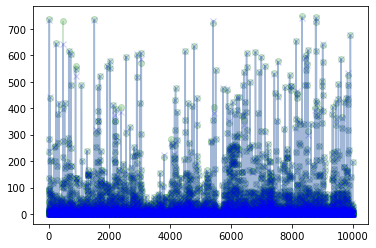

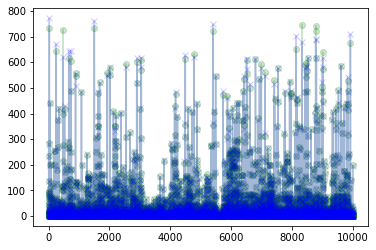

1.3787116740332304
[0]	validation_0-rmse:39.35400	validation_1-rmse:39.85528
[500]	validation_0-rmse:0.44604	validation_1-rmse:0.58143
[1000]	validation_0-rmse:0.41828	validation_1-rmse:0.56850
[1500]	validation_0-rmse:0.40550	validation_1-rmse:0.56683
[1531]	validation_0-rmse:0.40487	validation_1-rmse:0.56681
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.920518	training's l2: 0.847354	valid_1's rmse: 2.11595	valid_1's l2: 4.47723
Early stopping, best iteration is:
[661]	training's rmse: 0.842341	training's l2: 0.709538	valid_1's rmse: 2.08938	valid_1's l2: 4.36549


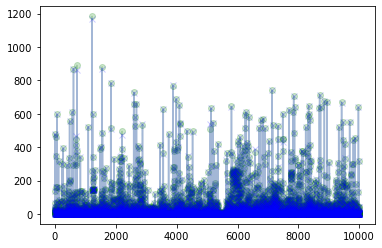

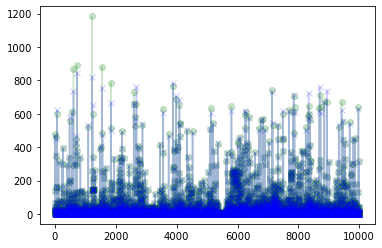

2.089375926737455
[0]	validation_0-rmse:39.43169	validation_1-rmse:39.15019
[500]	validation_0-rmse:0.44184	validation_1-rmse:0.70119
[1000]	validation_0-rmse:0.41745	validation_1-rmse:0.69159
[1500]	validation_0-rmse:0.40466	validation_1-rmse:0.68916
[2000]	validation_0-rmse:0.39525	validation_1-rmse:0.68808
[2500]	validation_0-rmse:0.38690	validation_1-rmse:0.68764
[2645]	validation_0-rmse:0.38465	validation_1-rmse:0.68757
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.874819	training's l2: 0.765308	valid_1's rmse: 1.23745	valid_1's l2: 1.53128
[1000]	training's rmse: 0.69984	training's l2: 0.489776	valid_1's rmse: 1.22691	valid_1's l2: 1.50531
Early stopping, best iteration is:
[844]	training's rmse: 0.738744	training's l2: 0.545743	valid_1's rmse: 1.22478	valid_1's l2: 1.50007


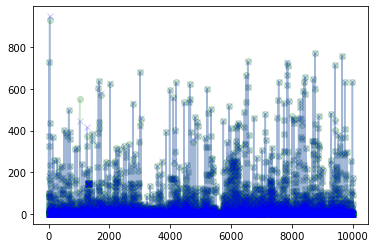

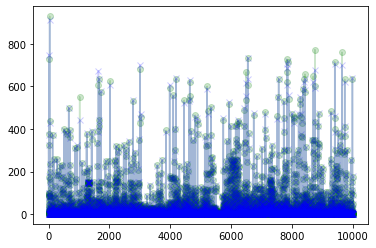

1.2247754522713974
[0]	validation_0-rmse:39.43491	validation_1-rmse:39.12780
[500]	validation_0-rmse:0.44512	validation_1-rmse:0.60299
[1000]	validation_0-rmse:0.41835	validation_1-rmse:0.59373
[1500]	validation_0-rmse:0.40570	validation_1-rmse:0.59235
[2000]	validation_0-rmse:0.39588	validation_1-rmse:0.59225
[2203]	validation_0-rmse:0.39253	validation_1-rmse:0.59246
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.906518	training's l2: 0.821775	valid_1's rmse: 1.48876	valid_1's l2: 2.21642
Early stopping, best iteration is:
[676]	training's rmse: 0.834841	training's l2: 0.696959	valid_1's rmse: 1.47188	valid_1's l2: 2.16642


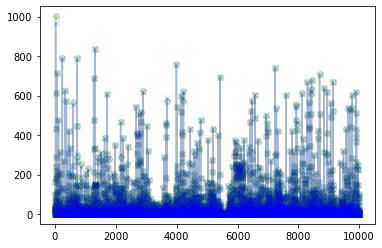

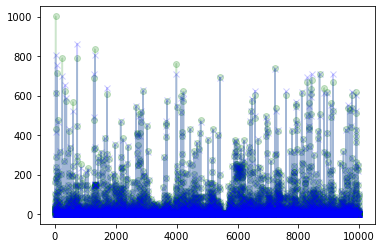

1.4718756658660435
[0]	validation_0-rmse:39.39601	validation_1-rmse:39.44793
[500]	validation_0-rmse:0.44561	validation_1-rmse:0.57355
[1000]	validation_0-rmse:0.41825	validation_1-rmse:0.56067
[1500]	validation_0-rmse:0.40562	validation_1-rmse:0.55910
[1969]	validation_0-rmse:0.39648	validation_1-rmse:0.55958
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.89586	training's l2: 0.802565	valid_1's rmse: 2.11772	valid_1's l2: 4.48476
Early stopping, best iteration is:
[384]	training's rmse: 0.958064	training's l2: 0.917887	valid_1's rmse: 2.11246	valid_1's l2: 4.46251


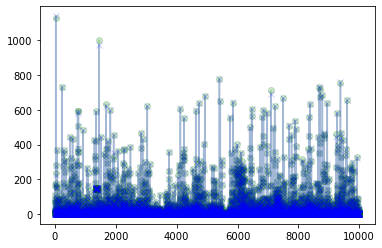

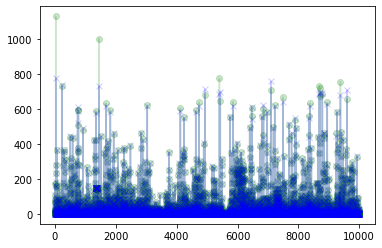

2.1124647819852806
[0]	validation_0-rmse:39.40628	validation_1-rmse:39.40017
[500]	validation_0-rmse:0.44497	validation_1-rmse:0.59004
[1000]	validation_0-rmse:0.41808	validation_1-rmse:0.57859
[1500]	validation_0-rmse:0.40554	validation_1-rmse:0.57744
[2000]	validation_0-rmse:0.39594	validation_1-rmse:0.57678
[2300]	validation_0-rmse:0.39069	validation_1-rmse:0.57703
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.966982	training's l2: 0.935055	valid_1's rmse: 2.77445	valid_1's l2: 7.69756
Early stopping, best iteration is:
[253]	training's rmse: 1.23748	training's l2: 1.53135	valid_1's rmse: 2.74545	valid_1's l2: 7.53749


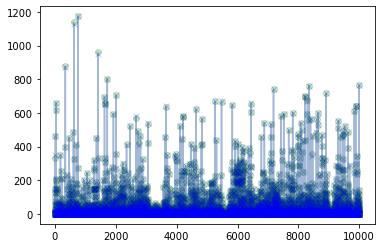

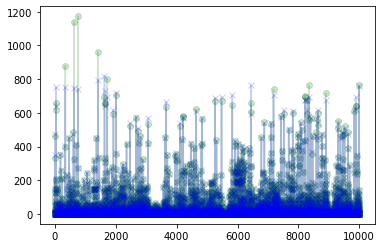

2.7454481369948476
[0]	validation_0-rmse:39.32326	validation_1-rmse:40.20042
[500]	validation_0-rmse:0.44512	validation_1-rmse:0.62421
[1000]	validation_0-rmse:0.41853	validation_1-rmse:0.61362
[1500]	validation_0-rmse:0.40585	validation_1-rmse:0.61279
[1521]	validation_0-rmse:0.40542	validation_1-rmse:0.61286
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[144]	training's rmse: 1.35569	training's l2: 1.83789	valid_1's rmse: 1.50993	valid_1's l2: 2.27989


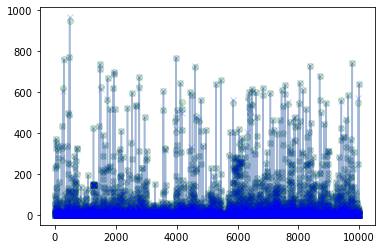

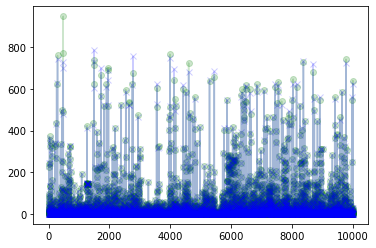

1.509930092678756
[0]	validation_0-rmse:39.39220	validation_1-rmse:39.52409
[500]	validation_0-rmse:0.44587	validation_1-rmse:0.61470
[1000]	validation_0-rmse:0.41816	validation_1-rmse:0.60273
[1500]	validation_0-rmse:0.40573	validation_1-rmse:0.60106
[1883]	validation_0-rmse:0.39803	validation_1-rmse:0.60114
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[71]	training's rmse: 1.66299	training's l2: 2.76554	valid_1's rmse: 1.80168	valid_1's l2: 3.24604


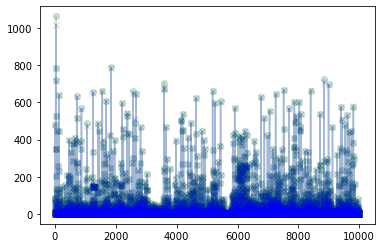

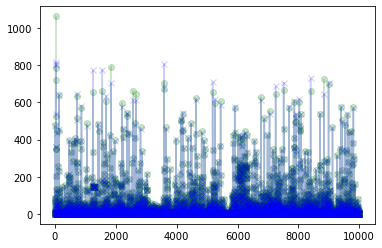

1.8016778675928253
[0]	validation_0-rmse:39.48063	validation_1-rmse:38.68380
[500]	validation_0-rmse:0.44478	validation_1-rmse:0.59898
[1000]	validation_0-rmse:0.41813	validation_1-rmse:0.58509
[1500]	validation_0-rmse:0.40556	validation_1-rmse:0.58349
[1760]	validation_0-rmse:0.40035	validation_1-rmse:0.58395
Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.926498	training's l2: 0.858399	valid_1's rmse: 1.17287	valid_1's l2: 1.37563
Early stopping, best iteration is:
[233]	training's rmse: 1.23123	training's l2: 1.51592	valid_1's rmse: 1.14697	valid_1's l2: 1.31554


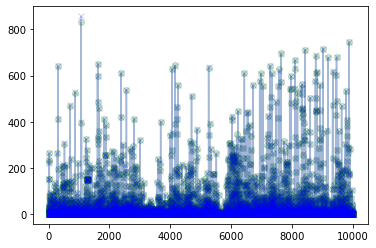

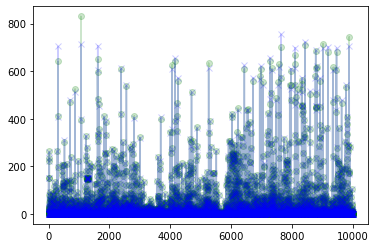

1.1469677807795784


In [27]:
models = []
rmse_score_mean=0
xgb_rmse_score=0
xgb_models=[]
folds = KFold(n_splits=10,shuffle=True,random_state=2021)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_x.reset_index(drop = True, inplace=True)
    val_y = train_label[val_idx]
    val_y.reset_index(drop = True, inplace=True)
    ## xgb
    xgb=XGBRegressor(**xgb_param,)
    xgb.fit(train_x, train_y,
              eval_set=[(train_x,train_y),(val_x, val_y)],
              eval_metric='rmse',
              early_stopping_rounds=300,
            verbose=500,
             )
    ##lgbm
    model=LGBMRegressor(**param)
    model.fit(train_x, train_y,
              eval_set=[(train_x,train_y),(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500,
             )
    
    pred=xgb.predict(val_x)
    plt.plot(val_y[:10000],color='green',marker='o',alpha=0.2)
    plt.plot(pred[:10000],color='blue',marker='x',alpha=0.2)
    plt.show()

    pred=model.predict(val_x)
    plt.plot(val_y[:10000],color='green',marker='o',alpha=0.2)
    plt.plot(pred[:10000],color='blue',marker='x',alpha=0.2)
    plt.show()
    models.append(model)
    xgb_models.append(xgb)
    print(mean_squared_error(model.predict(val_x),val_y)**0.5)

    rmse_score_mean+=mean_squared_error(model.predict(val_x),val_y)**0.5

/opt/homebrew/Caskroom/miniforge/base/envs/PSNR/lib/python3.8/site-packages/lightgbm/plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


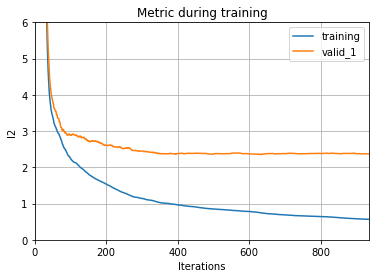

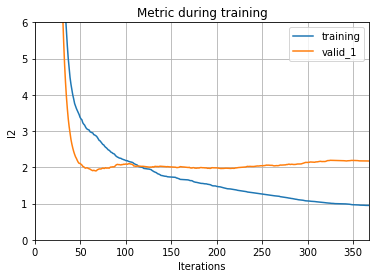

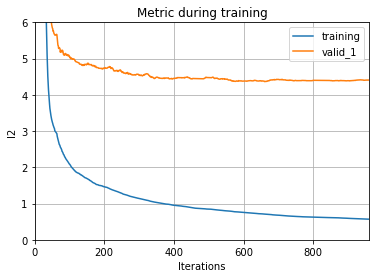

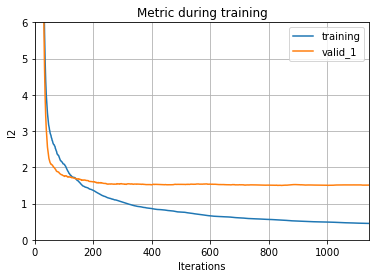

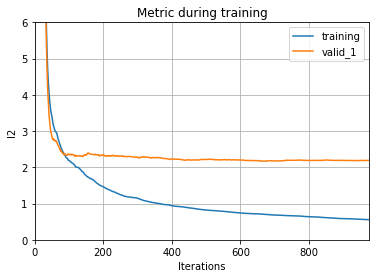

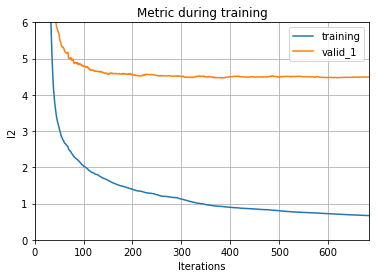

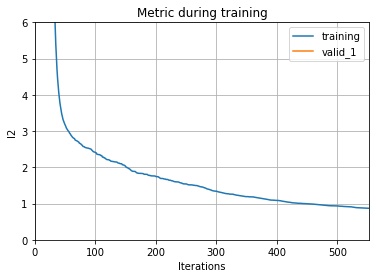

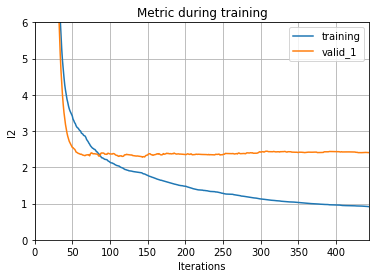

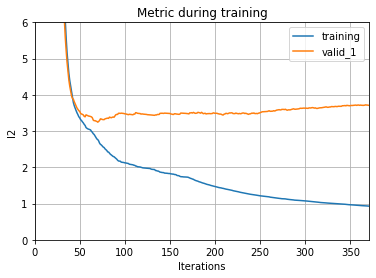

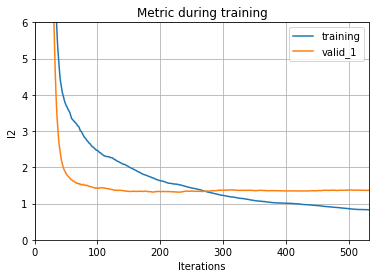

In [28]:
import lightgbm
lgbm_models=models
for i in range(len(lgbm_models)):
    lightgbm.plot_metric(lgbm_models[i], metric=None, dataset_names=None, ax=None, xlim=None, ylim=(0,6), title='Metric during training', xlabel='Iterations', ylabel='auto', figsize=None, dpi=None, grid=True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

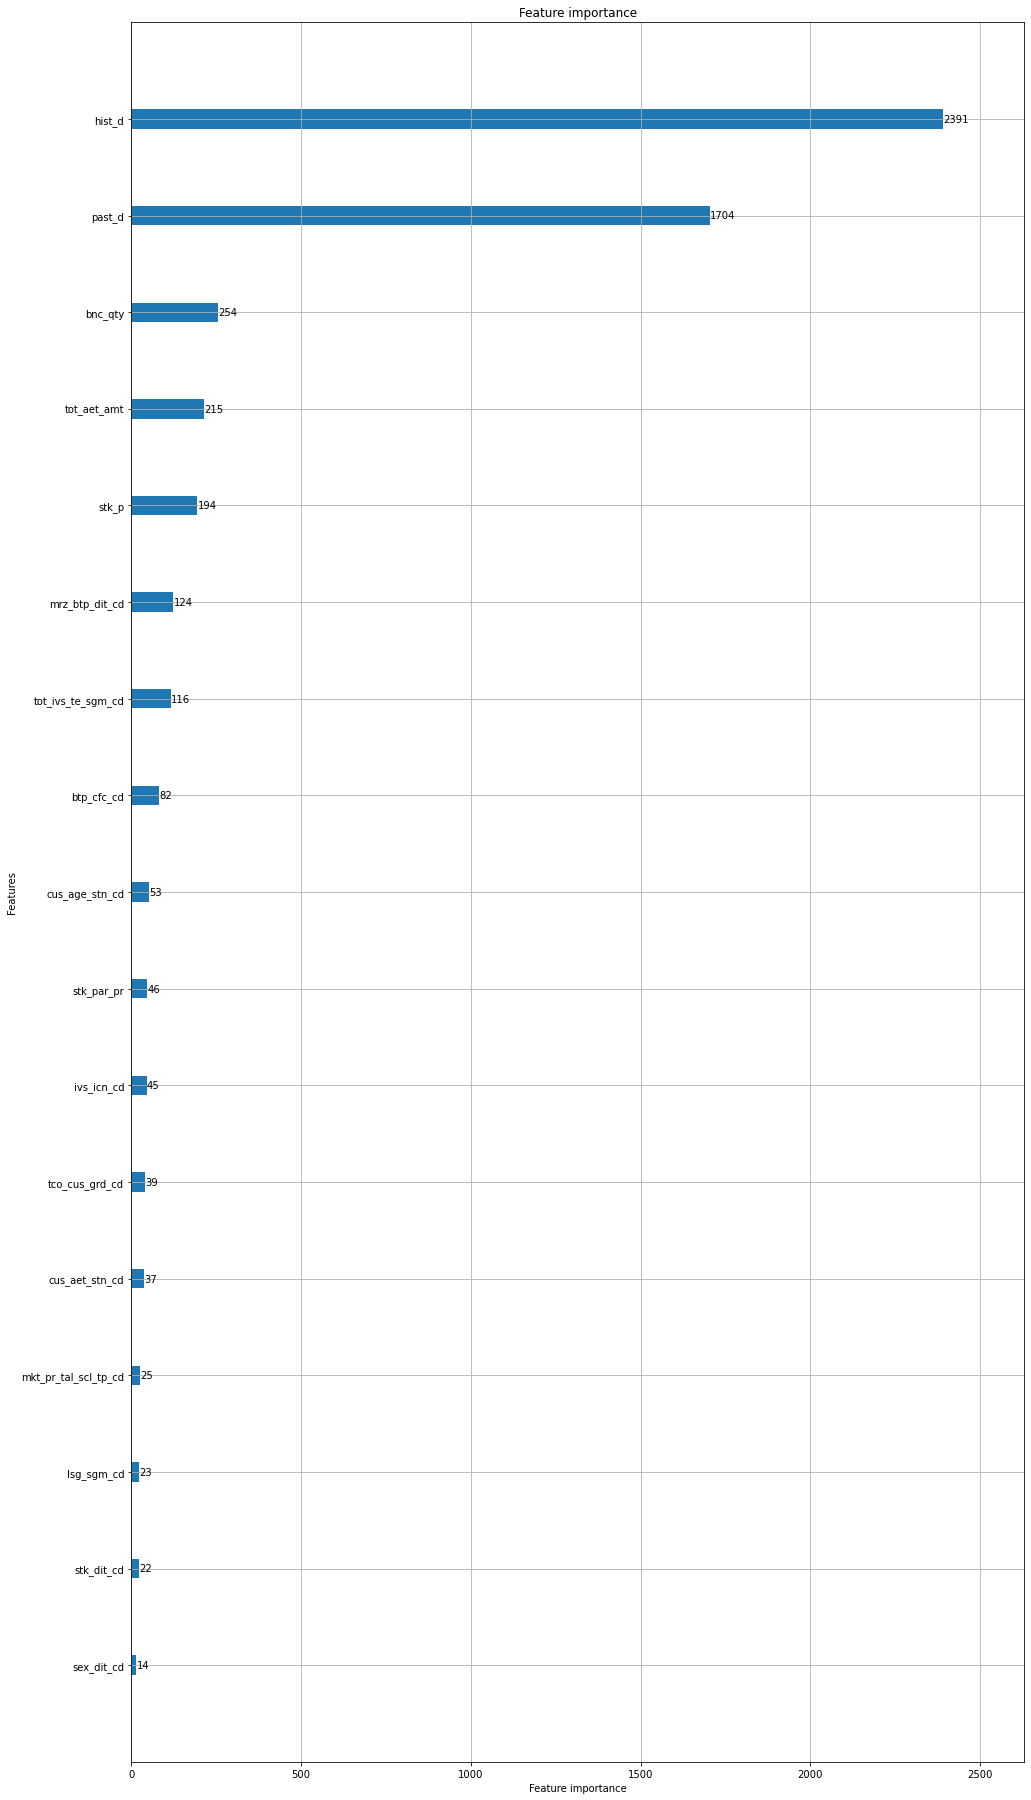

In [29]:
from lightgbm import plot_importance

plot_importance(model, figsize=(16, 32))

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
rmse_score_mean=0
xgb_rmse_score=0
lgbm_models=models

for i in range(len(lgbm_models)):
    
    rmse_score_mean+=mean_squared_error(lgbm_models[i].predict(val_x),val_y)**0.5
    xgb_rmse_score+=mean_squared_error(xgb_models[i].predict(val_x),val_y)**0.5
    print("xgb_score:",xgb_rmse_score)
    print("lgbm_score:",mean_squared_error(lgbm_models[i].predict(val_x),val_y)**0.5)
#rmse_score_mean=rmse_score_mean/len(models)
#print(f'rmse_score_mean:{xgb_rmse_score/len(xgb_models)}')
print(f'rmse_score_mean:{rmse_score_mean/len(lgbm_models)}')
print(f'rmse_score_mean:{xgb_rmse_score/len(xgb_models)}')

xgb_score: 0.4003792473817396
lgbm_score: 0.76945653767055
xgb_score: 0.7993750845061248
lgbm_score: 1.1739307787923978
xgb_score: 1.2107064088116934
lgbm_score: 0.7771586771494211
xgb_score: 1.5993392677068279
lgbm_score: 0.6989488211633911
xgb_score: 1.9962392828705209
lgbm_score: 0.7380716517850024
xgb_score: 2.3975517994107842
lgbm_score: 0.8187333514164046
xgb_score: 2.792960571756363
lgbm_score: 1.004493044140383
xgb_score: 3.204023737512329
lgbm_score: 0.9553095466304645
xgb_score: 3.607428669316911
lgbm_score: 1.145452029445582
xgb_score: 4.190828129826282
lgbm_score: 1.1469677807795784
rmse_score_mean:0.9228522218973174
rmse_score_mean:0.4190828129826282


In [31]:
result = []
xgb_result=[]
for i in models:
    result.append(i.predict(test_data))
for i in xgb_models:
    xgb_result.append(i.predict(test_data))
xgb_predict=np.mean(xgb_result,axis=0)
predict = np.mean(result, axis = 0)
print(predict)
print(xgb_predict)
print(0.2*predict+0.8*xgb_predict)

[306.42476583 795.55360583 278.99643893 ... 741.46061518  22.64899355
   8.54191364]
[ 306.12228   671.56726   278.31274  ... 1172.4314     22.562592
    8.487421]
[ 306.18278031  696.36456638  278.44948005 ... 1086.23725243   22.57987233
    8.49831975]


In [32]:
import datetime
import pytz
KST = pytz.timezone('Asia/Seoul')
datetime.datetime.today().year
today_time=datetime.datetime.now(KST)
name=str(int(today_time.year))+":"+str(int(today_time.month))+":"+str(int(today_time.day))+":"+str(int(today_time.hour))+":"+str(int(today_time.minute))

In [33]:
print(rmse_score_mean/len(lgbm_models))
predict=0.2*predict+0.8*xgb_predict
for i in range(len(predict)):
    predict[i]=np.round(predict[i])

0.9228522218973174


In [34]:
h=np.array(test_data['hist_d'])
h=h+146
h

array([ 299.        ,  481.        ,  285.        , ..., 1004.        ,
        154.64285714,  148.66666667])

In [35]:
for i in range(len(predict)):
    if predict[i]>=h[i]:
        predict[i]=np.round(h[i])
print(h.shape,predict.shape)
predict

(70596,) (70596,)


array([ 299.,  481.,  278., ..., 1004.,   23.,    8.])

In [36]:
name
os.mkdir('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/날짜별코드및제출파일/2021-08-30(제출완료)/'+name)
os.chdir('/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/날짜별코드및제출파일/2021-08-30(제출완료)/'+name)

In [37]:
r=pd.DataFrame(index=['model'])
for key,value in param.items():
    r[key]=value
r

r['rmse']=np.array(rmse_score_mean/len(lgbm_models)).reshape(1)

In [38]:
r['date']=name
best_param=pd.concat([best_param,r],axis=0)

In [39]:
submission["hold_d"] = np.round(predict)
submission.to_csv(name+"my_result.csv", index = False)

In [40]:
best_param.to_csv("/Users/pn_jh/Desktop/프로젝트/NH투자증권빅데이터경진대회/날짜별코드및제출파일/best_param.csv",index=False)